<div style="border:solid Chocolate 2px; padding: 40px">

<b> Андрей, привет!👋</b>

Меня зовут Алексей Гриб, я буду твоим ментором на протяжении финального спринта:)
    
Сразу хочу предложить в дальнейшем общаться на "ты" - надеюсь, так будет комфортнее:) Но если это неудобно, обязательно дай знать, и мы придумаем что-нибудь ещё!
    
Цель нашей работы - не искать ошибки в твоём проекте, а помочь тебе сделать его ещё лучше, устранив недочёты и приблизив его к реальным задачам аналитика. Поэтому не расстраивайся, если что-то не получилось с первого раза - это нормально, и это поможет тебе вырасти!
    
Ты можешь найти мои комментарии, обозначенные <font color='green'>зеленым</font>, <font color='gold'>желтым</font> и <font color='red'>красным</font> цветами, например:

<br/>

<div class="alert alert-success">
<h2> Комментарий ментора <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> похвала, рекомендации «со звёздочкой», полезные лайфхаки, которые сделают и без того красивое решение ещё более элегантным.
</div>

<br/>

<div class="alert alert-warning">
    <h2> Комментарий ментора <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> некритичные ошибки или развивающие рекомендации на будущее. 
</div>


<br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ментора <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
критичные ошибки, которые обязательно нужно исправить.
</div>

Я не смогу принять проект, если в нём будет хотя бы одна критичная ошибка или несколько некритичных ошибок - тогда проект нужно будет немного доработать. Но это нестрашно - я обязательно дам тебе подсказку или укажу верное направление.
    
Пожалуйста, не удаляй мои комментарии, они будут особенно полезны для нашей работы в случае повторной проверки проекта. 
    
Ты также можешь задавать свои вопросы, реагировать на мои комментарии, делать пометки и пояснения - полная творческая свобода! Но маленькая просьба - пускай они будут отличаться от моих комментариев, это поможет избежать путаницы в нашем общении:)
Например, вот так:
    
<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

*твой текст*
</div>
    
Давай посмотрим на твой проект!

# Введение

Оператор связи **«ТелеДом»** хочет снизить отток клиентов. Чтобы предлагать пользователям промокоды и специальные условия до того, как они решат уйти, компании нужна модель, которая предскажет вероятность расторжения договора.  

Для этого в распоряжении есть данные о клиентах, их тарифах и дополнительных услугах. Задача — обучить модель машинного обучения, которая поможет заранее определять абонентов, склонных к уходу.  

В рамках проекта нужно:  
- Подготовить и изучить данные;  
- Выбрать и обучить подходящую модель;  
- Оценить точность предсказаний;  
- Предложить решения по снижению оттока.  

Эта модель поможет **«ТелеДому»** вовремя реагировать на риск ухода клиентов и предлагать им выгодные условия для продолжения использования услуг.

<div class="alert alert-success">
<h2> Комментарий ментора <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Хорошее вступление!
    
В нём есть всё, что необходимо, чтобы понять суть проекта с первых строк отчёта!

## 1. Загрузка данных

In [41]:
import os
import pandas as pd
import numpy as np
import sqlite3
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, precision_recall_curve
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
import time

<div class="alert alert-success">
<h2> Комментарий ментора <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Библиотеки импортировали - отлично!

In [42]:
# Путь к базе данных
path = os.path.expanduser('~/final/')
path_to_db = os.path.join(path, 'ds-plus-final.db')

In [43]:
# Создаем соединение SQLite3
conn = sqlite3.connect(path_to_db)

In [44]:
# Получаем список таблиц
tables_list = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(list(tables_list['name']))

['data_arc', 'data_bulk', 'data_bulk_time', 'data_wire_time', 'contract', 'personal', 'phone', 'internet', 'data_gas', 'data_temp', 'data_wire']


In [45]:
# Функция для загрузки таблиц
def load_tables(conn, table_names):
    for table_name in table_names:
        query = f"SELECT * FROM {table_name};"
        df = pd.read_sql(query, conn)  # Используем соединение SQLite3
        globals()[f"{table_name}_df"] = df  # Создаем глобальную переменную

In [46]:
# Загружаем таблицы
table_names = ['contract', 'personal', 'phone', 'internet']
load_tables(conn, table_names)

# Закрываем соединение
conn.close()

In [47]:
contract_df

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.3,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.7,353.5
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.8,2035.2
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.2,7430.4
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.6,325.6
7041,8361-LTMKD,2019-07-01,No,Month-to-month,Yes,Mailed check,74.4,520.8


In [48]:
personal_df

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [49]:
internet_df

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [50]:
phone_df

,CustomerId,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


<div class="alert alert-success">
<h2> Комментарий ментора <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Данные загружены и осмотрены.

# Описание данных

Данные хранятся в **SQLite** — СУБД, в которой база данных представлена одним файлом. Она состоит из нескольких таблиц:

- **contract** — информация о договорах;
- **personal** — персональные данные клиентов;
- **internet** — информация об интернет-услугах;
- **phone** — информация об услугах телефонии.

---

## Таблица `contract`
| Поле               | Описание                                      |
|--------------------|----------------------------------------------|
| `customerID`      | ID абонента                                  |
| `BeginDate`       | Дата начала действия договора               |
| `EndDate`         | Дата окончания действия договора            |
| `Type`            | Тип оплаты: раз в год-два или ежемесячно    |
| `PaperlessBilling`| Электронный расчётный лист                  |
| `PaymentMethod`   | Тип платежа                                 |
| `MonthlyCharges`  | Расходы за месяц                           |
| `TotalCharges`    | Общие расходы абонента                     |

---

## Таблица `personal`
| Поле            | Описание                              |
|----------------|--------------------------------------|
| `customerID`  | ID пользователя                      |
| `gender`      | Пол                                  |
| `SeniorCitizen` | Является ли абонент пенсионером   |
| `Partner`     | Есть ли у абонента супруг(а)       |
| `Dependents`  | Есть ли у абонента дети            |

---

## Таблица `internet`
| Поле              | Описание                                      |
|------------------|----------------------------------------------|
| `customerID`    | ID пользователя                              |
| `InternetService` | Тип подключения                           |
| `OnlineSecurity` | Блокировка опасных сайтов                 |
| `OnlineBackup`   | Облачное хранилище файлов                 |
| `DeviceProtection` | Антивирус                               |
| `TechSupport`    | Выделенная линия технической поддержки    |
| `StreamingTV`    | Стриминговое телевидение                  |
| `StreamingMovies` | Каталог фильмов                         |

---

## Таблица `phone`
| Поле             | Описание                                      |
|-----------------|----------------------------------------------|
| `customerID`   | ID пользователя                              |
| `MultipleLines` | Подключение телефона к нескольким линиям   |

---

📅 **Информация о договорах актуальна на 1 февраля 2020.**


## 2. Исследовательский анализ  и предобработка данных

In [51]:
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   BeginDate         7043 non-null   object
 2   EndDate           7043 non-null   object
 3   Type              7043 non-null   object
 4   PaperlessBilling  7043 non-null   object
 5   PaymentMethod     7043 non-null   object
 6   MonthlyCharges    7043 non-null   object
 7   TotalCharges      7043 non-null   object
dtypes: object(8)
memory usage: 440.3+ KB


In [52]:
contract_df.describe()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,77,67,3,2,4,1585,6658
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,20.05,
freq,1,366,5942,3875,4171,2365,61,11


In [53]:
print('Типы оплаты: ', ', '.join(contract_df['Type'].unique()))
print('Наличие электронного расчётного листа: ', ', '.join(contract_df['PaperlessBilling'].unique()))
print('Тип платежа: ', ', '.join(contract_df['PaymentMethod'].unique()))

Типы оплаты:  Month-to-month, One year, Two year
Наличие электронного расчётного листа:  Yes, No
Тип платежа:  Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)


In [54]:
personal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   object
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


In [55]:
personal_df.describe()

,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043,7043,7043
unique,7043,2,2,2,2
top,7590-VHVEG,Male,0,No,No
freq,1,3555,5901,3641,4933


In [56]:
print('Пол: ', ', '.join(personal_df['gender'].unique()))
print('Является ли абонент пенсионером: ', ', '.join(personal_df['SeniorCitizen'].unique()))
print('Есть ли у абонента супруг(а): ', ', '.join(personal_df['Partner'].unique()))
print('Есть ли у абонента дети: ', ', '.join(personal_df['Dependents'].unique()))

Пол:  Female, Male
Является ли абонент пенсионером:  0, 1
Есть ли у абонента супруг(а):  Yes, No
Есть ли у абонента дети:  No, Yes


In [57]:
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [58]:
internet_df.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [59]:
print('Тип подключения: ', ', '.join(internet_df['InternetService'].unique()))
print('Блокировка опасных сайтов: ', ', '.join(internet_df['OnlineSecurity'].unique()))
print('Облачное хранилище сайтов: ', ', '.join(internet_df['OnlineBackup'].unique()))
print('Антивирус: ', ', '.join(internet_df['DeviceProtection'].unique()))
print('Выделенная линия технической поддержки: ', ', '.join(internet_df['TechSupport'].unique()))
print('Стриминговое телевидение: ', ', '.join(internet_df['StreamingTV'].unique()))
print('Каталог фильмов: ', ', '.join(internet_df['StreamingMovies'].unique()))

Тип подключения:  DSL, Fiber optic
Блокировка опасных сайтов:  No, Yes
Облачное хранилище сайтов:  Yes, No
Антивирус:  No, Yes
Выделенная линия технической поддержки:  No, Yes
Стриминговое телевидение:  No, Yes
Каталог фильмов:  No, Yes


In [60]:
phone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerId     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [61]:
print('Количество уникальных абонентов: ', phone_df['CustomerId'].nunique())
print('Подключение телефона к нескольким линиям: ', ', '.join(phone_df['MultipleLines'].unique()))

Количество уникальных абонентов:  6361
Подключение телефона к нескольким линиям:  No, Yes


### Вывод
В таблицах отсутствуют пропуски и дубликаты. Необходимо преобразовать все даты (`BeginDate`, `EndDate`) в формат `datetime64`, числовые значения (`MonthlyCharges`, `TotalCharges`) в `float` или `int`, а бинарные признаки (`Partner`, `Dependents`, `MultipleLines`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`, `SeniorCitizen`, `PaperlessBilling`) в `bool`, заменив `Yes` на `True`, а `No` на `False`.

In [62]:
merged_df = contract_df.merge(
    personal_df, on='customerID', how='left').merge(
    internet_df, on='customerID', how='left').merge(
    phone_df, left_on='customerID', right_on='CustomerId', how='left')

merged_df

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,CustomerId,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,DSL,No,Yes,No,No,No,No,NaN,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,5575-GNVDE,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,3668-QPYBK,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.3,1960.6,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,NaN,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.7,353.5,Female,0,...,No,Fiber optic,No,No,No,No,No,No,9237-HQITU,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.8,2035.2,Male,0,...,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,6840-RESVB,Yes
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.2,7430.4,Female,0,...,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,2234-XADUH,Yes
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.6,325.6,Female,0,...,Yes,DSL,Yes,No,No,No,No,No,NaN,NaN
7041,8361-LTMKD,2019-07-01,No,Month-to-month,Yes,Mailed check,74.4,520.8,Male,1,...,No,Fiber optic,No,No,No,No,No,No,8361-LTMKD,Yes


In [63]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   BeginDate         7043 non-null   object
 2   EndDate           7043 non-null   object
 3   Type              7043 non-null   object
 4   PaperlessBilling  7043 non-null   object
 5   PaymentMethod     7043 non-null   object
 6   MonthlyCharges    7043 non-null   object
 7   TotalCharges      7043 non-null   object
 8   gender            7043 non-null   object
 9   SeniorCitizen     7043 non-null   object
 10  Partner           7043 non-null   object
 11  Dependents        7043 non-null   object
 12  InternetService   5517 non-null   object
 13  OnlineSecurity    5517 non-null   object
 14  OnlineBackup      5517 non-null   object
 15  DeviceProtection  5517 non-null   object
 16  TechSupport       5517 non-null   object
 17  StreamingTV   

<div class="alert alert-success">
<h2> Комментарий ментора <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Соединение данных выполнено верно.

In [64]:
merged_df.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
CustomerId           682
MultipleLines        682
dtype: int64

In [65]:
merged_df.drop(columns=['customerID','CustomerId'], axis=1, inplace=True)

In [66]:
merged_df.fillna({'InternetService' : False, 
                  'OnlineSecurity' : False, 
                  'OnlineBackup' : False,
                  'DeviceProtection' : False, 
                  'TechSupport' : False, 
                  'StreamingTV' : False, 
                  'StreamingMovies' : False,
                  }, inplace=True)

<div class="alert alert-block alert-danger">
<h2> Комментарий ментора <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> В таблице `phone` представлены клиенты, у которых подключена телефония, а признаки с дополнительными услугами принимают значение `Yes` или `No` в зависимости от того, есть ли у клиента дополнительные услуги. Но основная услуга подключена, если клиент есть в таблице. Аналогично по таблице `internet` - есть основная услуга интернета и может быть или не быть дополнительных услуг. 
    
При соединении таблиц пропуски появляются у тех клиентов, которые не пользуются основной услугой: если есть пропуски в признаках из `Internet`, значит, клиент не пользуется основной услугой, значит и дополнительных услуг тоже быть не может. То же с телефонией. Если мы заменяем пропуск на `No`, мы искажаем историю обслуживания клиента, говоря, что у него есть основная услуга, но нет дополнительной, хотя на самом деле клиент не пользуется основной услугой. 
    
На какое значение можем заменить пропуск, чтобы описать этот новый сценарий?

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

В ходе предварительной обработки данных столбец `'MultipleLines'` был интерпретирован следующим образом: пропущенные значения отражают отсутствие телефонной линии у клиента, значение `'No'` соответствует наличию одной линии, а `'Yes'` — двум и более линиям. Для упрощения анализа и подготовки данных к моделированию было принято решение закодировать данный признак в числовом формате:  
- 0 — отсутствие линии,  
- 1 — одна линия,  
- 2 — две и более линий.    
    
Такой подход позволит корректно учитывать информацию при обучении моделей.
</div>

In [68]:
merged_df['MultipleLines'] = merged_df['MultipleLines'].replace({'No' : 1, 'Yes' : 2}).fillna(0).astype(int)
merged_df

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,0
1,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,1
2,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,1
3,2016-05-01,No,One year,No,Bank transfer (automatic),42.3,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,0
4,2019-09-01,No,Month-to-month,Yes,Electronic check,70.7,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2018-02-01,No,One year,Yes,Mailed check,84.8,2035.2,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,2
7039,2014-02-01,No,One year,Yes,Credit card (automatic),103.2,7430.4,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,2
7040,2019-03-01,No,Month-to-month,Yes,Electronic check,29.6,325.6,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,0
7041,2019-07-01,No,Month-to-month,Yes,Mailed check,74.4,520.8,Male,1,Yes,No,Fiber optic,No,No,No,No,No,No,2


In [27]:
merged_df.isna().sum()

BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

In [28]:
merged_df

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,False
1,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,2016-05-01,No,One year,No,Bank transfer (automatic),42.3,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,False
4,2019-09-01,No,Month-to-month,Yes,Electronic check,70.7,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2018-02-01,No,One year,Yes,Mailed check,84.8,2035.2,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,2014-02-01,No,One year,Yes,Credit card (automatic),103.2,7430.4,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,2019-03-01,No,Month-to-month,Yes,Electronic check,29.6,325.6,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,False
7041,2019-07-01,No,Month-to-month,Yes,Mailed check,74.4,520.8,Male,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes


In [29]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   BeginDate         7043 non-null   object
 1   EndDate           7043 non-null   object
 2   Type              7043 non-null   object
 3   PaperlessBilling  7043 non-null   object
 4   PaymentMethod     7043 non-null   object
 5   MonthlyCharges    7043 non-null   object
 6   TotalCharges      7043 non-null   object
 7   gender            7043 non-null   object
 8   SeniorCitizen     7043 non-null   object
 9   Partner           7043 non-null   object
 10  Dependents        7043 non-null   object
 11  InternetService   7043 non-null   object
 12  OnlineSecurity    7043 non-null   object
 13  OnlineBackup      7043 non-null   object
 14  DeviceProtection  7043 non-null   object
 15  TechSupport       7043 non-null   object
 16  StreamingTV       7043 non-null   object
 17  StreamingMovie

In [30]:
merged_df['EndDate'] = merged_df['EndDate'].replace({'No' : '2020-02-01'}) 
merged_df

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,False
1,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.3,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,False
4,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.7,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.8,2035.2,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.2,7430.4,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.6,325.6,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,False
7041,2019-07-01,2020-02-01,Month-to-month,Yes,Mailed check,74.4,520.8,Male,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes


In [ ]:
df_new = merged_df.copy()
pd.set_option('future.no_silent_downcasting', True)
df_new = df_new.replace({'No': False, 'Yes': True, '0': False, '1': True})

<div class="alert alert-block alert-danger">
<h2> Комментарий менторра <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Кодирование нельзя делать руками:
- при появлении новых значений категориальных признаков, не предусмотренных твоим решением, модель или упадёт, или будет генерировать ошибки;
- такое решение не сделаешь частью `Pipeline`, а все современные решения базируются на них.
    
Поэтому кодирование нужно делать только с применением обучаемых трансформеров. 
Кодирование данных также нужно осуществлять только после сплитования - так мы не допускаем утечку данных из тестовой части, а также можем контролировать появление в `test` новых значений категориальных признаков.

In [31]:
df_new['InternetService'] = df_new['InternetService'].replace(False, 'No')
df_new

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,2020-01-01,2020-02-01,Month-to-month,True,Electronic check,29.85,31.04,Female,False,True,False,DSL,False,True,False,False,False,False,False
1,2017-04-01,2020-02-01,One year,False,Mailed check,56.95,2071.84,Male,False,False,False,DSL,True,False,True,False,False,False,False
2,2019-10-01,2020-02-01,Month-to-month,True,Mailed check,53.85,226.17,Male,False,False,False,DSL,True,True,False,False,False,False,False
3,2016-05-01,2020-02-01,One year,False,Bank transfer (automatic),42.3,1960.6,Male,False,False,False,DSL,True,False,True,True,False,False,False
4,2019-09-01,2020-02-01,Month-to-month,True,Electronic check,70.7,353.5,Female,False,False,False,Fiber optic,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2018-02-01,2020-02-01,One year,True,Mailed check,84.8,2035.2,Male,False,True,True,DSL,True,False,True,True,True,True,True
7039,2014-02-01,2020-02-01,One year,True,Credit card (automatic),103.2,7430.4,Female,False,True,True,Fiber optic,False,True,True,False,True,True,True
7040,2019-03-01,2020-02-01,Month-to-month,True,Electronic check,29.6,325.6,Female,False,True,True,DSL,True,False,False,False,False,False,False
7041,2019-07-01,2020-02-01,Month-to-month,True,Mailed check,74.4,520.8,Male,True,True,False,Fiber optic,False,False,False,False,False,False,True


In [32]:
df_new[['BeginDate', 'EndDate']] = df_new[['BeginDate', 'EndDate']].apply(pd.to_datetime, format = '%Y-%m-%d')

In [33]:
df_new['MonthlyCharges'] = df_new['MonthlyCharges'].astype('float')

In [34]:
df_new['TotalCharges'] = df_new['TotalCharges'].replace(" ", np.nan).astype('float')

In [35]:
df_new['active_status'] = df_new['EndDate'].apply(lambda x: True if x == pd.to_datetime('2020-02-01') else False)
df_new.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,active_status
0,2020-01-01,2020-02-01,Month-to-month,True,Electronic check,29.85,31.04,Female,False,True,False,DSL,False,True,False,False,False,False,False,True
1,2017-04-01,2020-02-01,One year,False,Mailed check,56.95,2071.84,Male,False,False,False,DSL,True,False,True,False,False,False,False,True
2,2019-10-01,2020-02-01,Month-to-month,True,Mailed check,53.85,226.17,Male,False,False,False,DSL,True,True,False,False,False,False,False,True
3,2016-05-01,2020-02-01,One year,False,Bank transfer (automatic),42.30,1960.60,Male,False,False,False,DSL,True,False,True,True,False,False,False,True
4,2019-09-01,2020-02-01,Month-to-month,True,Electronic check,70.70,353.50,Female,False,False,False,Fiber optic,False,False,False,False,False,False,False,True


<div class="alert alert-block alert-danger">
<h2> Комментарий ментора <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
Давай подумаем, будет ли твоё решение корректно работать для случаев, когда клиент уходит в день выгрузки?

In [36]:
df_new['active_period'] = (df_new['EndDate'] - df_new['BeginDate']).dt.days + 1 
df_new.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,active_status,active_period
0,2020-01-01,2020-02-01,Month-to-month,True,Electronic check,29.85,31.04,Female,False,True,...,DSL,False,True,False,False,False,False,False,True,32
1,2017-04-01,2020-02-01,One year,False,Mailed check,56.95,2071.84,Male,False,False,...,DSL,True,False,True,False,False,False,False,True,1037
2,2019-10-01,2020-02-01,Month-to-month,True,Mailed check,53.85,226.17,Male,False,False,...,DSL,True,True,False,False,False,False,False,True,124
3,2016-05-01,2020-02-01,One year,False,Bank transfer (automatic),42.30,1960.60,Male,False,False,...,DSL,True,False,True,True,False,False,False,True,1372
4,2019-09-01,2020-02-01,Month-to-month,True,Electronic check,70.70,353.50,Female,False,False,...,Fiber optic,False,False,False,False,False,False,False,True,154


<div class="alert alert-success">
<h2> Комментарий ментора <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Выделена длительность контракта.

<div class="alert alert-block alert-danger">
<h2> Комментарий ментора <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Подскажи, пожалуйста, зачем прибавляем один день?

In [37]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7032 non-null   float64       
 7   gender            7043 non-null   object        
 8   SeniorCitizen     7043 non-null   object        
 9   Partner           7043 non-null   object        
 10  Dependents        7043 non-null   object        
 11  InternetService   7043 non-null   object        
 12  OnlineSecurity    7043 non-null   object        
 13  OnlineBackup      7043 non-null   object        
 14  DeviceProtection  7043 n

In [38]:
df_new.drop(columns=['BeginDate', 'EndDate'], axis=1, inplace=True)
df_new

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,active_status,active_period
0,Month-to-month,True,Electronic check,29.85,31.04,Female,False,True,False,DSL,False,True,False,False,False,False,False,True,32
1,One year,False,Mailed check,56.95,2071.84,Male,False,False,False,DSL,True,False,True,False,False,False,False,True,1037
2,Month-to-month,True,Mailed check,53.85,226.17,Male,False,False,False,DSL,True,True,False,False,False,False,False,True,124
3,One year,False,Bank transfer (automatic),42.30,1960.60,Male,False,False,False,DSL,True,False,True,True,False,False,False,True,1372
4,Month-to-month,True,Electronic check,70.70,353.50,Female,False,False,False,Fiber optic,False,False,False,False,False,False,False,True,154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,One year,True,Mailed check,84.80,2035.20,Male,False,True,True,DSL,True,False,True,True,True,True,True,True,731
7039,One year,True,Credit card (automatic),103.20,7430.40,Female,False,True,True,Fiber optic,False,True,True,False,True,True,True,True,2192
7040,Month-to-month,True,Electronic check,29.60,325.60,Female,False,True,True,DSL,True,False,False,False,False,False,False,True,338
7041,Month-to-month,True,Mailed check,74.40,520.80,Male,True,True,False,Fiber optic,False,False,False,False,False,False,True,True,216


In [39]:
df_new.rename(columns={'Type' : 'type', 
                       'PaperlessBilling' : 'paperless_billing', 
                       'PaymentMethod' : 'payment_method', 
                       'MonthlyCharges' : 'monthly_charges',
                       'TotalCharges' : 'total_charges', 
                       'SeniorCitizen' : 'senior_citizen', 
                       'Partner' : 'partner', 
                       'Dependents' : 'dependents',
                       'InternetService' : 'internet_service', 
                       'OnlineSecurity' : 'online_security', 
                       'OnlineBackup' : 'online_backup', 
                       'DeviceProtection' : 'device_protection', 
                       'TechSupport' : 'tech_support', 
                       'StreamingTV' : 'streaming_tv', 
                       'StreamingMovies' : 'streaming_movies', 
                       'MultipleLines' : 'multiple_lines'}, inplace=True)
df_new.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,active_status,active_period
0,Month-to-month,True,Electronic check,29.85,31.04,Female,False,True,False,DSL,False,True,False,False,False,False,False,True,32
1,One year,False,Mailed check,56.95,2071.84,Male,False,False,False,DSL,True,False,True,False,False,False,False,True,1037
2,Month-to-month,True,Mailed check,53.85,226.17,Male,False,False,False,DSL,True,True,False,False,False,False,False,True,124
3,One year,False,Bank transfer (automatic),42.30,1960.60,Male,False,False,False,DSL,True,False,True,True,False,False,False,True,1372
4,Month-to-month,True,Electronic check,70.70,353.50,Female,False,False,False,Fiber optic,False,False,False,False,False,False,False,True,154


In [40]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7032 non-null   float64
 5   gender             7043 non-null   object 
 6   senior_citizen     7043 non-null   object 
 7   partner            7043 non-null   object 
 8   dependents         7043 non-null   object 
 9   internet_service   7043 non-null   object 
 10  online_security    7043 non-null   object 
 11  online_backup      7043 non-null   object 
 12  device_protection  7043 non-null   object 
 13  tech_support       7043 non-null   object 
 14  streaming_tv       7043 non-null   object 
 15  streaming_movies   7043 non-null   object 
 16  multiple_lines     7043 

In [41]:
df_new['total_charges'] = df_new['total_charges'].fillna(df_new['monthly_charges'])
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   gender             7043 non-null   object 
 6   senior_citizen     7043 non-null   object 
 7   partner            7043 non-null   object 
 8   dependents         7043 non-null   object 
 9   internet_service   7043 non-null   object 
 10  online_security    7043 non-null   object 
 11  online_backup      7043 non-null   object 
 12  device_protection  7043 non-null   object 
 13  tech_support       7043 non-null   object 
 14  streaming_tv       7043 non-null   object 
 15  streaming_movies   7043 non-null   object 
 16  multiple_lines     7043 

<div class="alert alert-success">
<h2> Комментарий ментора <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Пропуски этого типа обработаны верно.

<div class="alert alert-block alert-danger">
<h2> Комментарий ментора <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Важно обосновать выбор стратегии для обработки этих пропусков.

In [42]:
df_new[['paperless_billing', 
        'senior_citizen', 
        'partner',
        'dependents',
        'online_security', 
        'online_backup', 
        'device_protection', 
        'tech_support', 
        'streaming_tv', 
        'multiple_lines',
        'streaming_movies']] = df_new[['paperless_billing', 
                                       'senior_citizen', 
                                       'partner',
                                       'dependents',
                                       'online_security', 
                                       'online_backup', 
                                       'device_protection', 
                                       'tech_support', 
                                       'streaming_tv', 
                                       'multiple_lines',
                                       'streaming_movies']].astype(bool) 
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   bool   
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   gender             7043 non-null   object 
 6   senior_citizen     7043 non-null   bool   
 7   partner            7043 non-null   bool   
 8   dependents         7043 non-null   bool   
 9   internet_service   7043 non-null   object 
 10  online_security    7043 non-null   bool   
 11  online_backup      7043 non-null   bool   
 12  device_protection  7043 non-null   bool   
 13  tech_support       7043 non-null   bool   
 14  streaming_tv       7043 non-null   bool   
 15  streaming_movies   7043 non-null   bool   
 16  multiple_lines     7043 

In [43]:
df_new['avg_charges_months'] = df_new['total_charges'] / df_new['active_period'] * 30
df_new['is_family'] = (df_new['partner'] | df_new['dependents'])
df_new['is_senior_alone'] = ((df_new['senior_citizen'] == 1) & (df_new['partner'] == 0) & (df_new['dependents'] == 0)).astype(bool)
df_new['extra_charges'] = df_new['monthly_charges'] - df_new['avg_charges_months']
df_new['is_single_mother'] = ((df_new['partner'] == 0) & (df_new['dependents'] == 1) & (df_new['gender'] == 'Female')).astype(bool)
df_new.head(10)

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,...,streaming_tv,streaming_movies,multiple_lines,active_status,active_period,avg_charges_months,is_family,is_senior_alone,extra_charges,is_single_mother
0,Month-to-month,True,Electronic check,29.85,31.04,Female,False,True,False,DSL,...,False,False,False,True,32,29.100000,True,False,0.750000,False
1,One year,False,Mailed check,56.95,2071.84,Male,False,False,False,DSL,...,False,False,False,True,1037,59.937512,False,False,-2.987512,False
2,Month-to-month,True,Mailed check,53.85,226.17,Male,False,False,False,DSL,...,False,False,False,True,124,54.718548,False,False,-0.868548,False
3,One year,False,Bank transfer (automatic),42.30,1960.60,Male,False,False,False,DSL,...,False,False,False,True,1372,42.870262,False,False,-0.570262,False
4,Month-to-month,True,Electronic check,70.70,353.50,Female,False,False,False,Fiber optic,...,False,False,False,True,154,68.863636,False,False,1.836364,False
5,Month-to-month,True,Electronic check,99.65,1150.96,Female,False,False,False,Fiber optic,...,True,True,True,True,338,102.156213,False,False,-2.506213,False
6,Month-to-month,True,Credit card (automatic),89.10,2058.21,Male,False,False,True,Fiber optic,...,True,False,True,True,672,91.884375,True,False,-2.784375,False
7,Month-to-month,False,Mailed check,29.75,300.48,Female,False,False,False,DSL,...,False,False,False,True,307,29.362866,False,False,0.387134,False
8,Month-to-month,True,Electronic check,104.80,3573.68,Female,False,True,False,Fiber optic,...,True,True,True,True,946,113.330233,True,False,-8.530233,False
9,One year,False,Bank transfer (automatic),56.15,1628.35,Male,False,False,True,DSL,...,False,False,False,False,883,55.323330,True,False,0.826670,False


<div class="alert alert-success">
<h2> Комментарий ментора <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Хорошая работа по созданию новых признаков.

In [44]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   type                7043 non-null   object 
 1   paperless_billing   7043 non-null   bool   
 2   payment_method      7043 non-null   object 
 3   monthly_charges     7043 non-null   float64
 4   total_charges       7043 non-null   float64
 5   gender              7043 non-null   object 
 6   senior_citizen      7043 non-null   bool   
 7   partner             7043 non-null   bool   
 8   dependents          7043 non-null   bool   
 9   internet_service    7043 non-null   object 
 10  online_security     7043 non-null   bool   
 11  online_backup       7043 non-null   bool   
 12  device_protection   7043 non-null   bool   
 13  tech_support        7043 non-null   bool   
 14  streaming_tv        7043 non-null   bool   
 15  streaming_movies    7043 non-null   bool   
 16  multip

In [45]:
df_new.isna().sum()

type                  0
paperless_billing     0
payment_method        0
monthly_charges       0
total_charges         0
gender                0
senior_citizen        0
partner               0
dependents            0
internet_service      0
online_security       0
online_backup         0
device_protection     0
tech_support          0
streaming_tv          0
streaming_movies      0
multiple_lines        0
active_status         0
active_period         0
avg_charges_months    0
is_family             0
is_senior_alone       0
extra_charges         0
is_single_mother      0
dtype: int64

## 3. Иследовательский анализ

In [46]:
phik_corr = df_new.phik_matrix()

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'active_period', 'avg_charges_months', 'extra_charges']


<div class="alert alert-block alert-danger">
<h2> Комментарий ментора <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
При использовании `phik` крайне важно настроить параметр `interval_cols`, передав ему список с названиями непрерывных признаков: если этого не сделать, библиотека своими силами будет пытаться разнести признаки по типам, и она часто делает в этом ошибки - от этого в свою очередь мы получаем некорректную оценку корреляций, так как от типа признака зависит метод оценки корреляции.

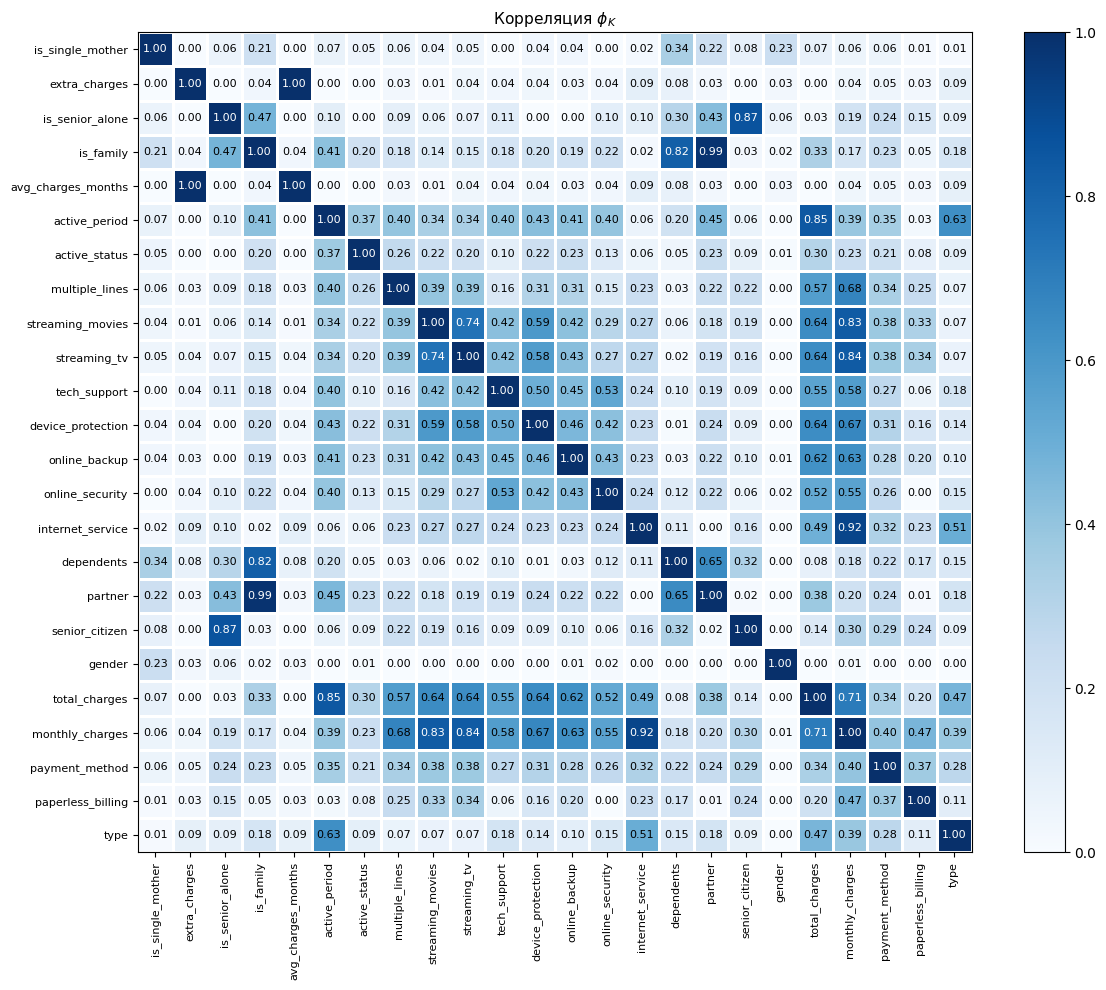

In [47]:
plot_correlation_matrix(phik_corr.values, 
                        x_labels=phik_corr.columns, 
                        y_labels=phik_corr.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title=r"Корреляция $\phi_K$", 
                        fontsize_factor=0.8, 
                        figsize=(12, 10))
plt.tight_layout()
plt.show()

### 📌 Признаки с максимальной кореляцией с `activestatus`:

| Признак              | Корреляция | Комментарий |
|----------------------|------------|----------------|
| `active_period`      | **0.37**   | Чем дольше клиент с компанией, тем выше шанс быть активным |
| `total_charges`      | **0.30**   | Клиенты, потратившие больше денег, чаще остаются |
| `multiple_lines`     | **0.26**   | Наличие нескольких линий связано с активностью |
| `online_backup`      | **0.23**   | Клиенты с облачным хранилещем дольше активны |
| `monthlycharges`     | **0.23**   | Более дорогой тариф — чаще остаются (возможно, более лояльны) |

---

### 🧊 Признаки со слабой корреляцией:

| Признак             | Корреляция | Комментарий |
|---------------------|------------|-------------|
| `gender`            | 0.01       | Пол почти не влияет |
| `dependents`        | 0.05       | Наличие детей — слабая связь |
| `internetservice`   | 0.06       | Тип интернета почти не влияет |

---

## 🧾 Вывод

1. **Самый значимый фактор активности клиента** — это **длительность обслуживания (`active_period`)** и **суммарные траты (`total_charges`)**.
2. **Дополнительные услуги (`online_backup`, `multiple_lines` и т.п.)** — позитивно связаны с активностью. Их наличие удерживает клиентов.
3. **Высокие ежемесячные платежи (`monthlycharges`)** тоже немного повышают шанс активности — возможно, такие клиенты больше завязаны на сервисе.
4. **Социальные параметры** (пол, партнёр, дети) почти не влияют на активность.

---

<div class="alert alert-success">
<h2> Комментарий ментора <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
    
Есть анализ корреляции - молодец, что используешь `phik` для анализа и нелинейных зависимостей.

In [48]:
def chart(index): 
    pivot_type = df_new.pivot_table(
        values='active_period', 
        columns='active_status', 
        index=index, 
        aggfunc='count'
    )
    pivot_type.columns = pivot_type.columns.astype(str)
    pivot_percent = pivot_type.copy().reset_index()
    cols = ['False', 'True']
    pivot_percent[cols] = pivot_percent[cols].div(pivot_percent[cols].sum(axis=1), axis=0) * 100
    pivot_percent.set_index(index)[cols].plot(kind='bar', stacked=True, figsize=(8, 5))
    plt.title(f'Процентное соотношение активных/неактивных по {index}')
    plt.ylabel('% клиентов')
    plt.xlabel(index)
    plt.legend(title='Active Status')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

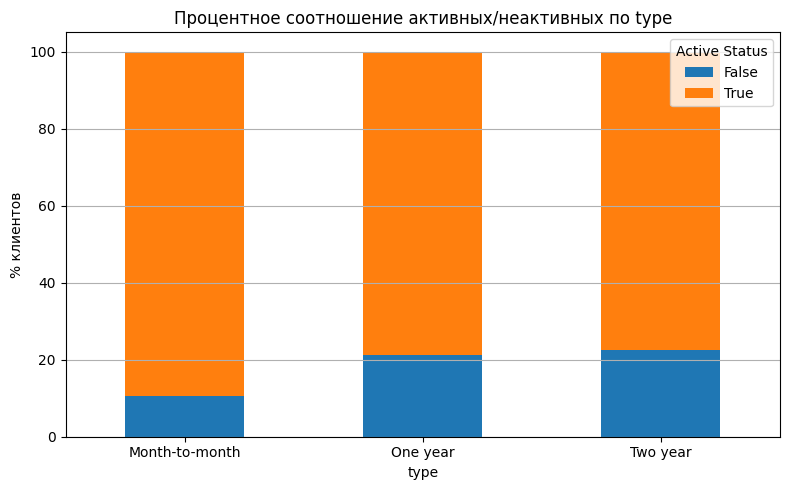

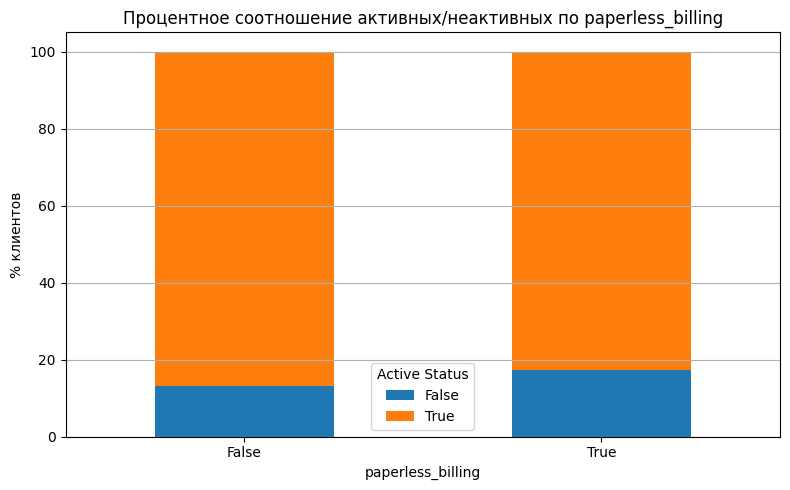

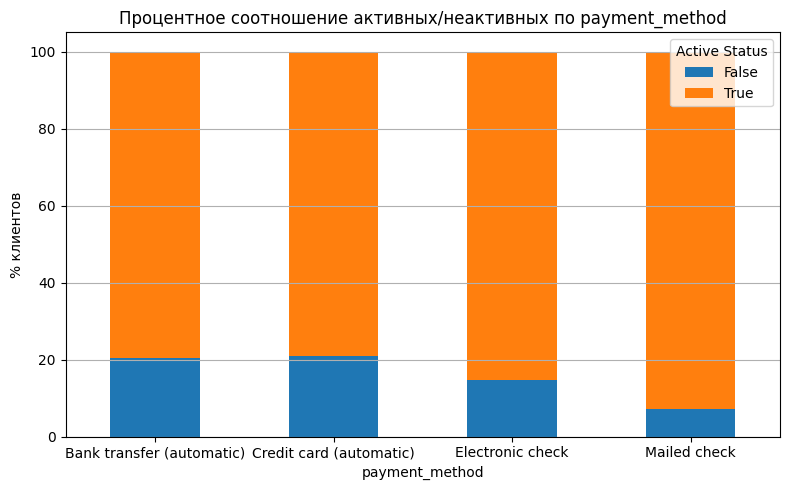

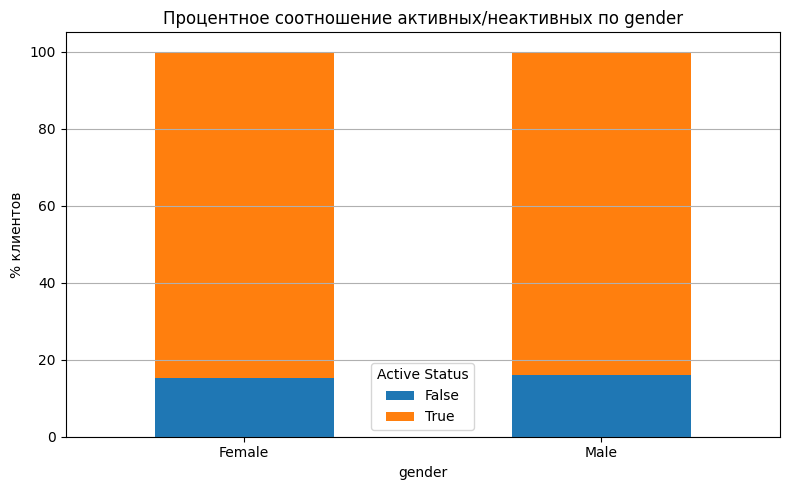

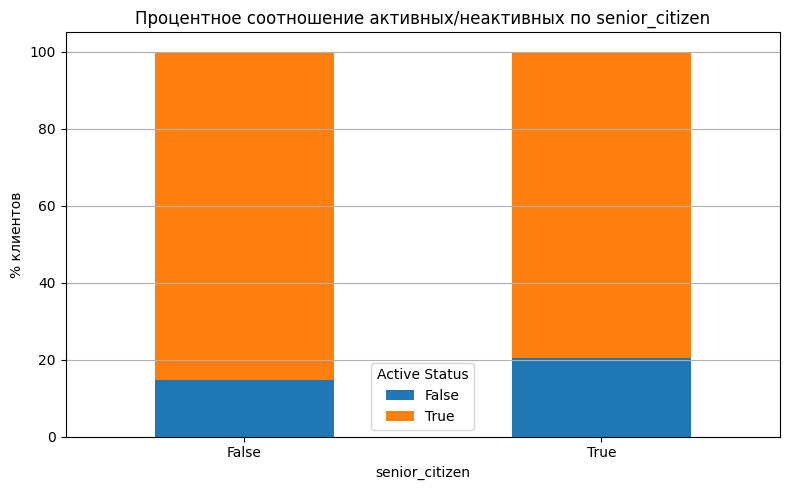

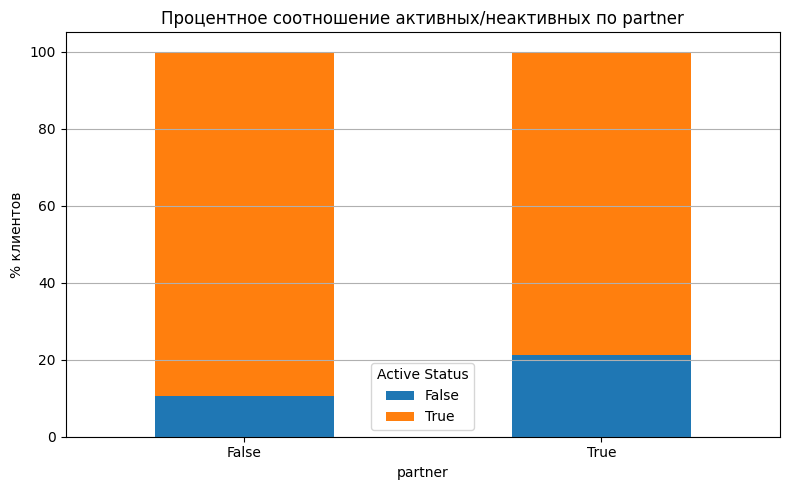

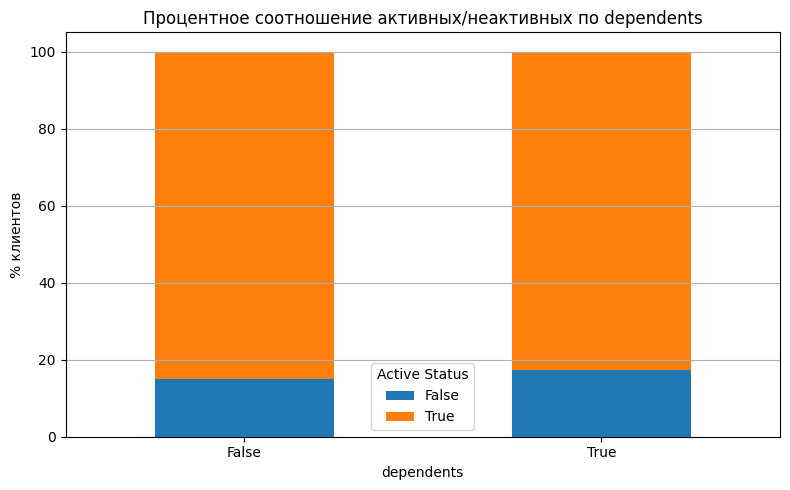

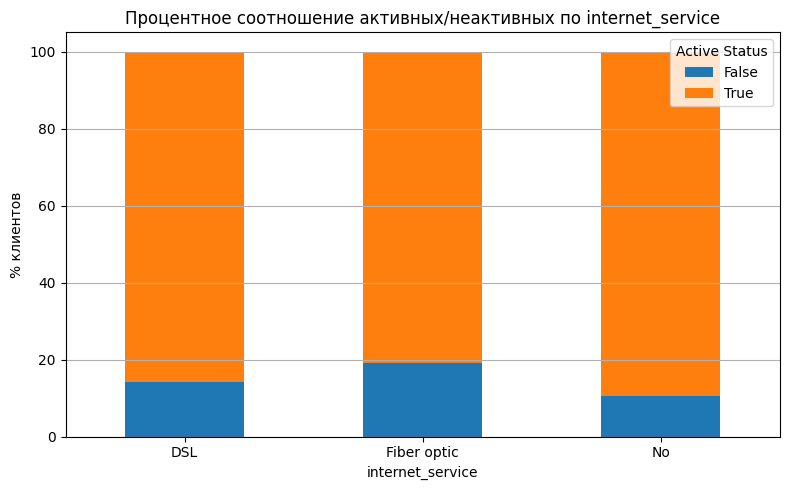

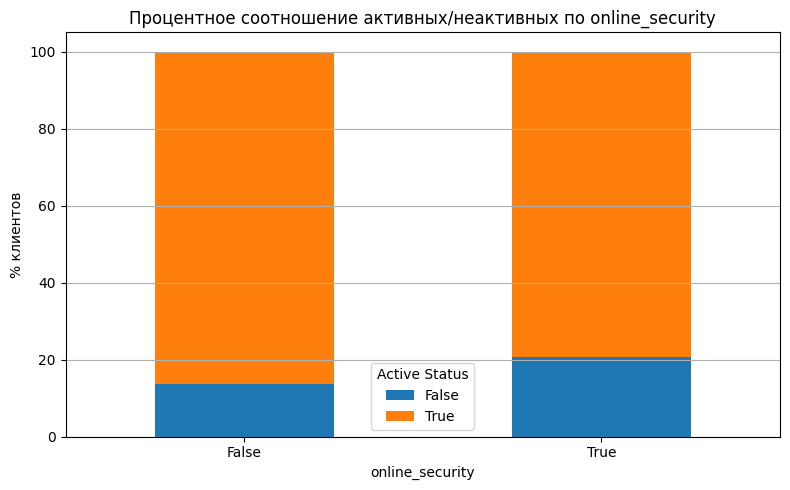

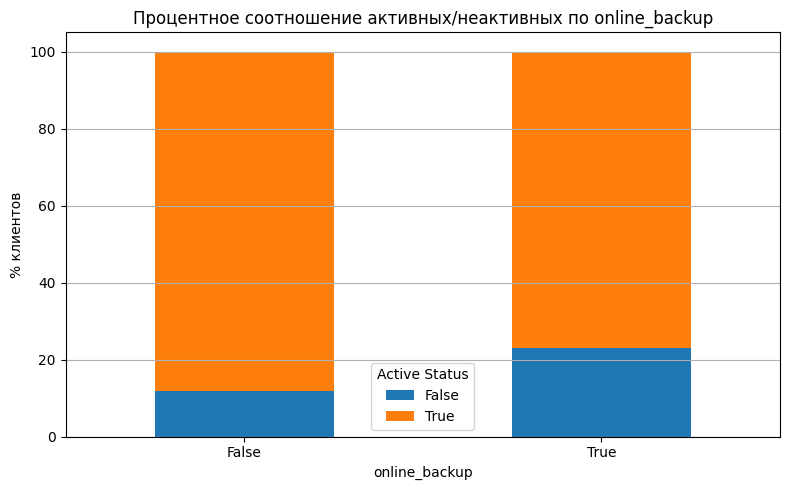

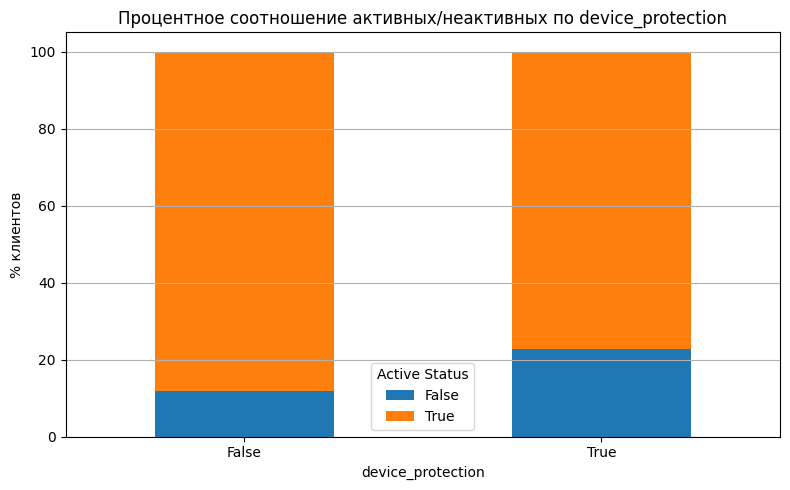

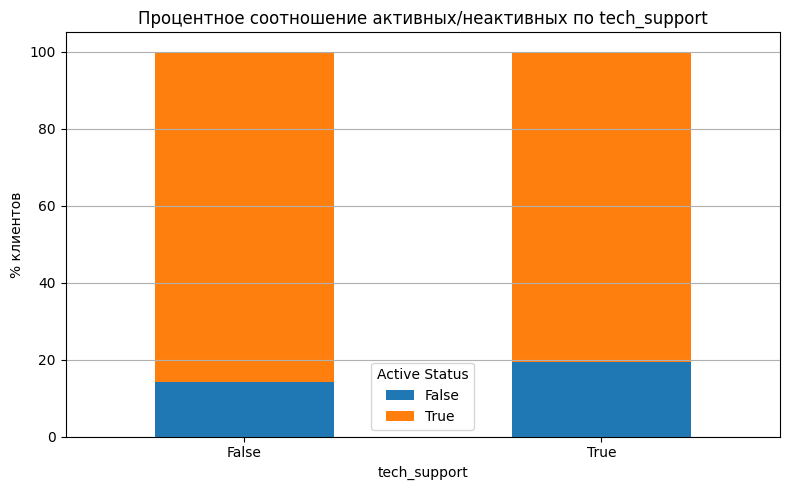

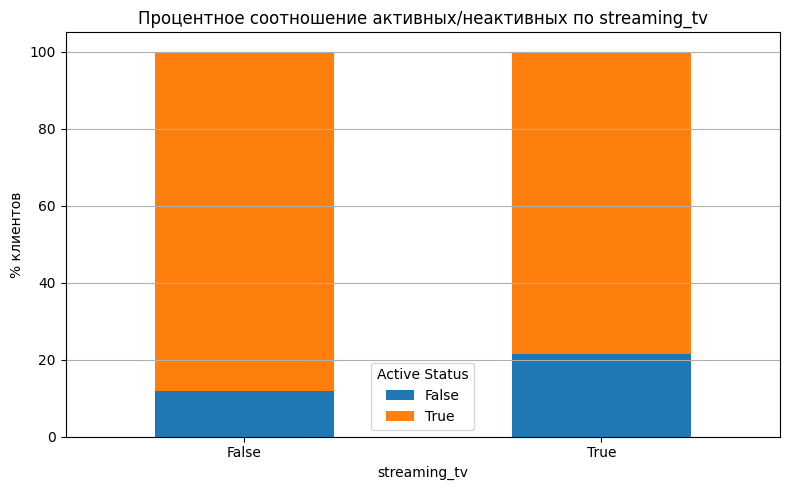

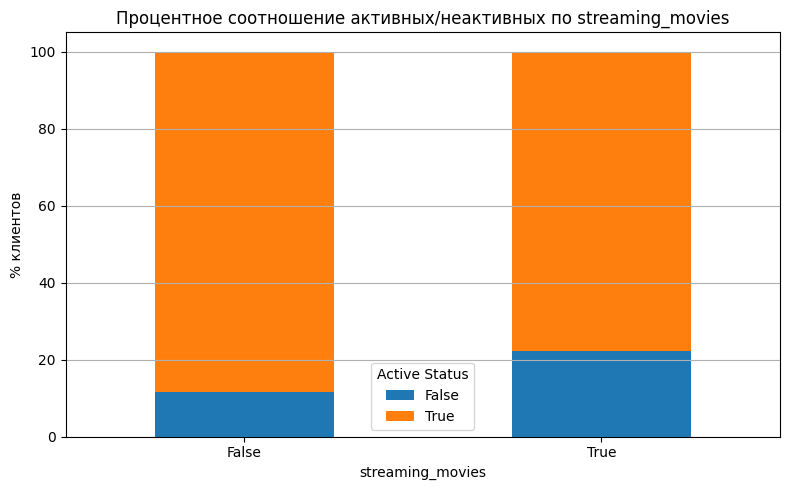

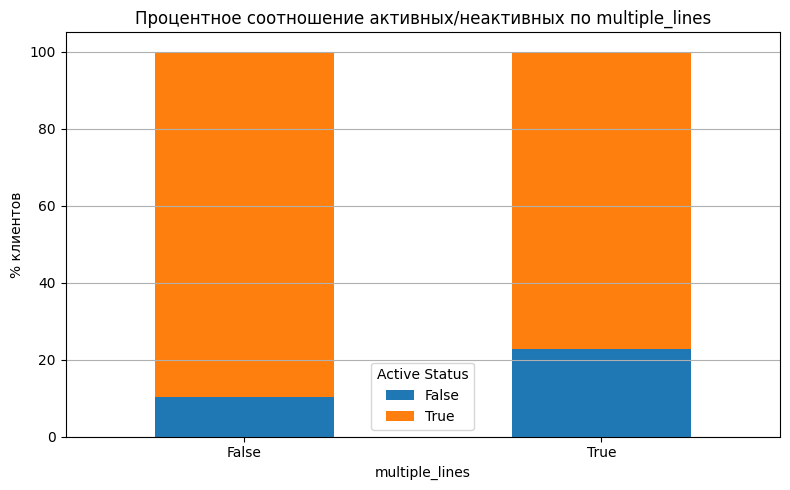

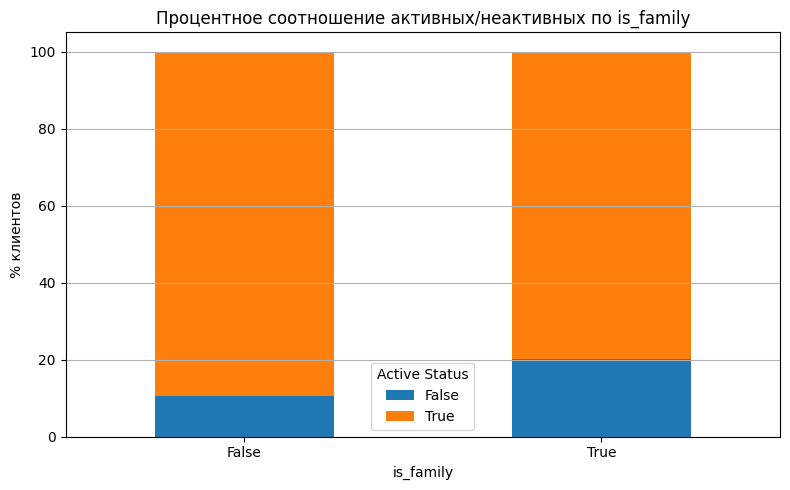

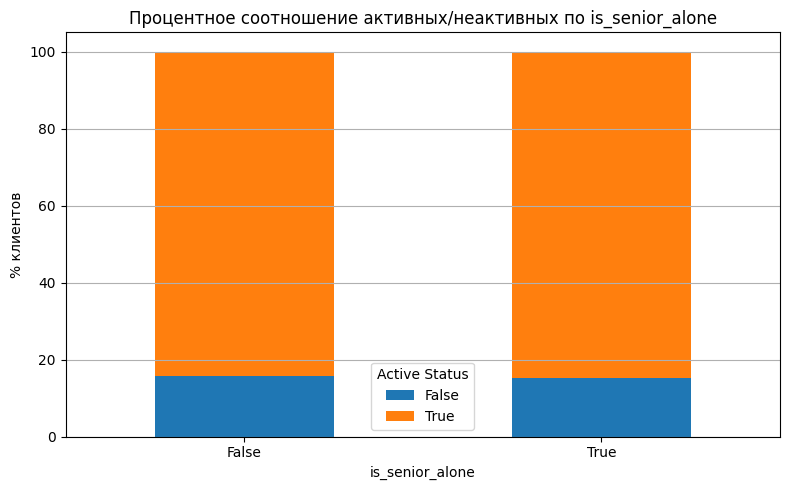

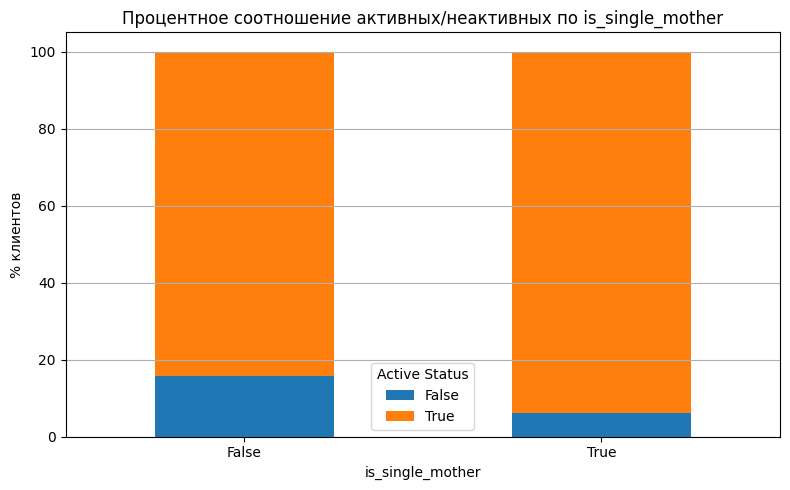

In [49]:
for col in df_new.columns:
    if col == 'active_status':
        continue  

    if df_new[col].dtype in ['object', 'bool'] and df_new[col].nunique() <= 10:
        try:
            chart(col)
        except Exception as e:
            print(f'Не удалось построить график для \"{col}\": {e}')

<div class="alert alert-success">
<h2> Комментарий ментора <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Круто, что делаешь анализ в разрезе оттока - ценность такого анализа выше в глазах заказчика, так как помогает ему лучше понять склонного к оттоку клиента.
    
Оставлю пару рекомендаций о том, как сделать его лучше:
- при анализе непрерывных переменных интерес представляет диапазон значений, при которых отток выше, чем сохранение пользователей - для такого анализа можно использовать `sns.histplot()` с `hue` в качестве призака оттока, а также параметрами `stat='density'` и `common_norm=False`, также важно корректно настроить количество корзин для получения максимально наглядного результата - оно определяется по формуле `max() - min() + 1`, также можно настроить параметр `binwidth=1` (либо то, либо другое), но для некоторых данных эти эвристики работают не всегда - в таком случае лучше подобрать перебором;
- при анализа категориальных/дискретных переменных нас также может интересовать, какое значение категории у признака более или менее отточное - для этого можно построить `sns.barplot()` с `x` в качестве признака, `y` в качестве признака оттока, а также `plt.axhline()` со средним уровнем оттока по компании для формирования трешхолда, при сравнении с котором мы бы определили, выше отток или ниже, чем в компании в среднем.
    
Также рекомендую делать анализ портрета клиента - это помогает компании понять типичного пользователя, который покидает компанию, чтобы что-то изменить в своих процессах. Его удобно организовать в виде сводной таблицы, где по столбцам будет признак оттока, на строках - признаки, а на пересечении - меры центральной тенденции: среднее или медиана для непрерывных и мода для категориальных:
    
                                   Отток    Не отток   Относительная разница
        
    Средняя зарплата
    Средний возраст
    Средний доход 
        
    Медианное количество продуктов
    Медианное количество собственности
        
    Мода по городу
    Мода по полу 

<div class="alert alert-block alert-danger">
<h2> Комментарий ментора <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Нет анализа непрерывных признаков.

In [50]:
df_new['multiple_lines'].unique()

array([False,  True])

## Вывод  
**Портрет клиента, склонного к расторжению договора:**

1. Выбирает оплату раз в 1–2 года  
2. Использует электронный счёт  
3. Предпочитает автоматическую оплату через банковский перевод или кредитную карту  
4. Пол не оказывает существенного влияния  
5. Является пенсионером  
6. Состоит в партнёрских отношениях  
7. Имеет детей на иждивении  
8. Подключён к оптоволоконному интернету  
9. Активно использует дополнительные услуги

## 4. Обучение модели

In [51]:
X = df_new.drop(columns=['active_status'], axis=1)
y = df_new['active_status'].astype(int)

In [52]:
num_col = ['monthly_charges', 
           'total_charges', 
           'active_period',
           'avg_charges_months',
           'extra_charges']         

In [53]:
ohe_col = ['type', 
           'payment_method', 
           'gender', 
           'internet_service']

In [54]:
ord_col = ['paperless_billing', 
           'senior_citizen', 
           'partner', 
           'dependents',
           'online_security', 
           'online_backup',
           'device_protection', 
           'tech_support', 
           'streaming_tv', 
           'streaming_movies',
           'multiple_lines',
           'is_family',
           'is_senior_alone',
           'is_family',
           'is_single_mother']

In [55]:
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(drop='first'), ohe_col),
        ('num', StandardScaler(), num_col),
        ('ord', OrdinalEncoder(), ord_col)
    ])

<div class="alert alert-block alert-danger">
<h2> Комментарий ментора <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> `OneHotEncoder` нужно настроить так, чтобы он обрабатывал новые значения признаков, а не выбрасывал ошибку - при текущей настройке `handle_unknown` в случае возникновения новых значений у признаков, которых не было в `train`, модель будет падать, а для многих случаев важна бесперебойность решений.
    
`OrdinalEncoder` нужно настраивать на бесперебойную работу при появлении в новых данных ранее неизвестных значений признаков: по умолчанию в таких случаях `OrdinalEncoder` будет выбрасывать ошибку, однако для непрерывности процесса моделирования можно настроить параметры `handle_unknown='use_encoded_value'`, чтобы новые, ранее неизвестные значения кодировались константным значением, а в параметр `unknown_value` нужно передать само значение-константу. 

In [56]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [57]:
param_grid = [
    {
        'classifier': [RandomForestClassifier(random_state=42)],
        'classifier__n_estimators': [200, 500],
        'classifier__max_depth': [10, 20, 50],
        'classifier__min_samples_split': [5, 7, 12],
    },
    {
        'classifier': [LGBMClassifier(random_state=42)],
        'classifier__scale_pos_weight': [1, 2, 5],
        'classifier__n_estimators': [500, 1000, 1700],
        'classifier__max_depth': [5, 10, 15],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__num_leaves': [5, 10, 12]
    },
    {
        'classifier': [MLPClassifier(max_iter=500, random_state=42)],
        'classifier__hidden_layer_sizes': [(100,), (100, 50)],
        'classifier__alpha': [0.0001, 0.001], 
        'classifier__learning_rate_init': [0.001, 0.01]
    }
]
param_grid

[{'classifier': [RandomForestClassifier(random_state=42)],
  'classifier__n_estimators': [200, 500],
  'classifier__max_depth': [10, 20, 50],
  'classifier__min_samples_split': [5, 7, 12]},
 {'classifier': [LGBMClassifier(random_state=42)],
  'classifier__scale_pos_weight': [1, 2, 5],
  'classifier__n_estimators': [500, 1000, 1700],
  'classifier__max_depth': [5, 10, 15],
  'classifier__learning_rate': [0.01, 0.1],
  'classifier__num_leaves': [5, 10, 12]},
 {'classifier': [MLPClassifier(max_iter=500, random_state=42)],
  'classifier__hidden_layer_sizes': [(100,), (100, 50)],
  'classifier__alpha': [0.0001, 0.001],
  'classifier__learning_rate_init': [0.001, 0.01]}]

In [58]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5634, 23), (1409, 23), (5634,), (1409,))

<div class="alert alert-block alert-danger">
<h2> Комментарий ментора <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Не соблюдена пропорция `test` выборки.

In [60]:
start_grid_searh = time.time()
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 188 candidates, totalling 940 fits
[LightGBM] [Info] Number of positive: 4737, number of negative: 897
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1249
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.840788 -> initscore=1.664103
[LightGBM] [Info] Start training from score 1.664103


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('ohe',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['type',
                                                                          'payment_method',
                                                                          'gender',
                                                                          'internet_service']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['monthly_charges',
                                                                          'total_charges',
                                                                          'active_period',
                                                                          'avg_charges_months',
                                                                          'extra_charges']),
                                                                        ('ord',
                                                                         OrdinalEncoder(),
                                                                         ['paperless_billing',
                                                                          'senior_c...
                          'classifier__max_depth': [5, 10, 15],
                          'classifier__n_estimators': [500, 1000, 1700],
                          'classifier__num_leaves': [5, 10, 12],
                          'classifier__scale_pos_weight': [1, 2, 5]},
                         {'classifier': [MLPClassifier(max_iter=500,
                                                       random_state=42)],
                          'classifier__alpha': [0.0001, 0.001],
                          'classifier__hidden_layer_sizes': [(100,), (100, 50)],
                          'classifier__learning_rate_init': [0.001, 0.01]}],
             scoring='roc_auc', verbose=2)

In [61]:
end_grid_search = time.time()
duration = (end_grid_search - start_grid_searh) / 60
duration

3.955010263125102

In [62]:
print('Лучшие параметры:', grid_search.best_params_ )

Лучшие параметры: {'classifier': LGBMClassifier(random_state=42), 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 1700, 'classifier__num_leaves': 5, 'classifier__scale_pos_weight': 1}


<div class="alert alert-success">
<h2> Комментарий ментора <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Найдена лучшая модель.

<div class="alert alert-block alert-danger">
<h2> Комментарий ментора <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Нужно вывести метрику лучшей модели на кросс-валидации из `best_score_`.

In [63]:
best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [64]:
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC AUC: {roc_auc:.4f}')

ROC AUC: 0.9232


<div class="alert alert-success">
    
<h2> Комментарий ментора <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Лучшую модель оценили на `test` - отличный результат!

In [65]:
y_pred = (y_pred_proba >= 0.86).astype(int)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.86


<div class="alert alert-success">
    
<h2> Комментарий ментора <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Есть оценка `Accuracy`.

<div class="alert alert-block alert-danger">
<h2> Комментарий ментора <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Для заказчика нужно интерпретировать, что показывает `Accuracy` при таком значении.

<div class="alert alert-warning">
    <h2> Комментарий ментора <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b>
Очень важно также проверить лучшую модель на адекватность, сравнив качество её предсказаний с качеством модели, которая предсказывала бы константу - вдруг окажется, что не было бы большого смысла заниматься созданием новых признаков, тюнингом и кросс-валидацией моделей, если можно было бы просто предсказывать среднее значение тренировочной выборки? 
    
В качестве константной модели можно использовать `DummyClassifier` (https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html#sklearn.dummy.DummyClassifier) -  эта модель как раз создана для генерирования константных предсказаний.
    
Важно, чтобы результат тестирования нашей модели на тествой выборке был лучше, чем результат константной модели - в противном случае наша модель является бесполезной, так как все наши усилия над проектом не принесли результата, а можель, просто предсказывющая среднее на `train`, делает нашу работу лучше.
        
Константная модель оценивается так же, как и любая другая модель - обучаем её на `train`, делаем предсказания для `test` и оцениваем их качество. Ничего сложного, я уверен, у тебя получится, а наличие проверки на адекватность повышает ценность твоего исследования:)

In [66]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.83      0.63       204
           1       0.97      0.86      0.91      1205

    accuracy                           0.86      1409
   macro avg       0.74      0.85      0.77      1409
weighted avg       0.90      0.86      0.87      1409



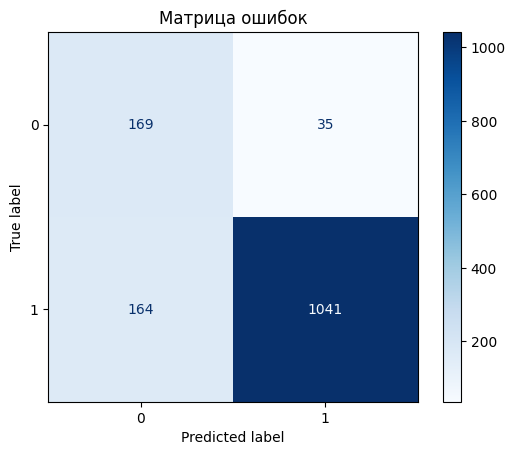

In [67]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Матрица ошибок")
plt.show()

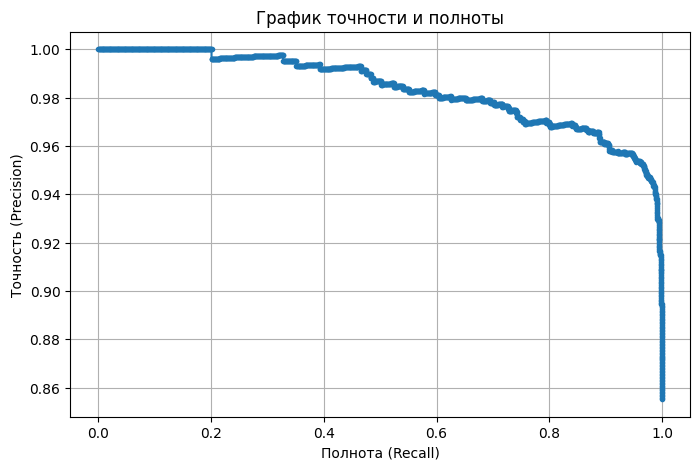

In [68]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 5))
plt.plot(recall, precision, marker='.')
plt.xlabel('Полнота (Recall)')
plt.ylabel('Точность (Precision)')
plt.title('График точности и полноты')
plt.grid(True)
plt.show()

<div class="alert alert-success">
    
<h2> Комментарий ментора <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Матрица ошибок, а также полнота и точность исследованы.

### 🔍 **Вывод:**

Модель достаточно **хорошо справляется с задачей нахождения клиентов, которые собираются уйти** — в большинстве случаев она правильно определяет таких людей. Это говорит о том, что **модель обладает высокой чувствительностью (или полнотой)**: она "замечает" почти всех уходящих.

Модель **иногда ошибочно считает, что лояльный клиент тоже может уйти** и на всякий случай поднимает тревогу даже там, где всё в порядке. 

---

### 💬 Что это значит:

Если компания может позволить себе предложить скидку или бонус, чтобы удержать клиента — даже если тот не собирался уходить, — это может быть выгоднее, чем потерять клиента, которого не заметили.

---

### ✅ Подходит для задач, где:

- **Важно не упустить** клиента, решившего уйти;
- **Лучше среагировать "впустую"**, чем ничего не сделать и потерять человека;
- Используется **персональный маркетинг**, скидки, промокоды.

---


<div class="alert alert-block alert-danger">
<h2> Комментарий ментора <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Интерпретацию матрицы ошибок стоит расширить: каждую из четыёх метрик матрицы ошибок нужно описать, а значения интерпретировать на понятном бизнесу языке. Метрики полноы и точности аналогично нужно интерпретировать.

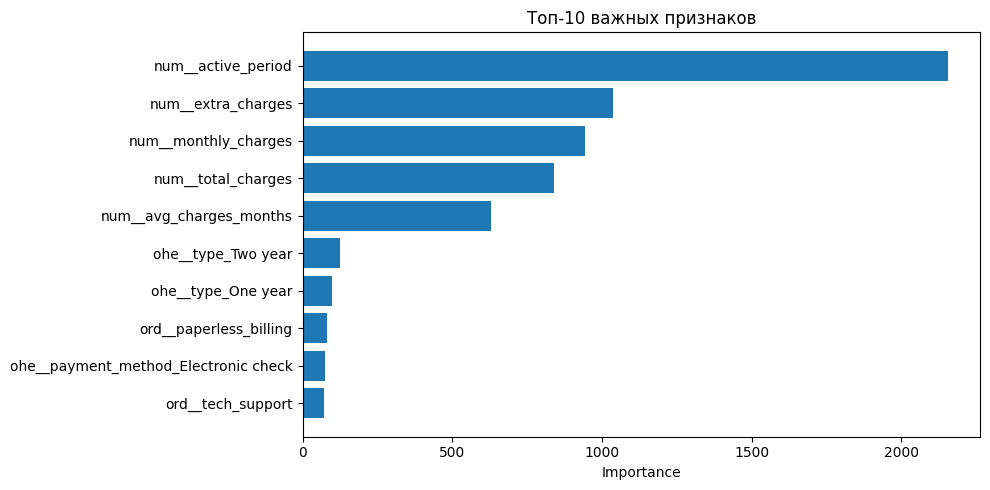

In [69]:
# Получаем имена признаков после препроцессинга
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
importances = best_model.named_steps['classifier'].feature_importances_

# Создаем DataFrame с важностями
feat_imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)

# Показываем топ-10 признаков
plt.figure(figsize=(10, 5))
plt.barh(feat_imp_df['feature'].head(10)[::-1], feat_imp_df['importance'].head(10)[::-1])
plt.xlabel("Importance")
plt.title("Топ-10 важных признаков")
plt.tight_layout()
plt.show()

<div class="alert alert-success">
    
<h2> Комментарий ментора <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Исследована важность признаков.

<div class="alert alert-block alert-danger">
<h2> Комментарий ментора <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Не забывай про подписи осей.

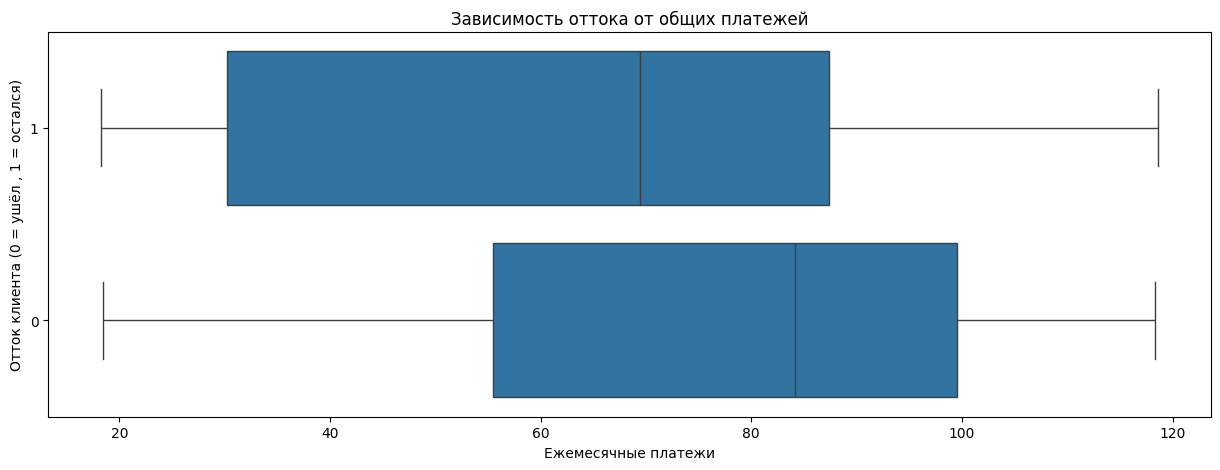

In [70]:
plt.figure(figsize=(15, 5))
sns.boxplot(y=y_train.astype(str), x=X_train['monthly_charges'])
plt.ylabel("Отток клиента (0 = ушёл , 1 = остался)")
plt.xlabel("Ежемесячные платежи")
plt.title("Зависимость оттока от общих платежей")
plt.show()

###  **Вывод:**

Судя по графику, клиенты, которые ушли, в среднем платили больше в месяц, чем те, кто остался, что может говорить о том, что высокие ежемесячные платежи становятся фактором риска оттока; таким клиентам стоит уделять особое внимание и при необходимости предлагать персональные условия или тарифы для удержания.

<div class="alert alert-success">
    
<h2> Комментарий ментора <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Есть анализ важного признака с целевым.

## 5. Общий вывод


---

## ✅ **Общий вывод**

В рамках проекта была разработана модель машинного обучения для прогнозирования оттока клиентов. Проведен анализ данных, выполнена предобработка признаков, обучены и протестированы несколько моделей: случайный лес, градиентный бустинг и нейронная сеть. В результате наилучшее качество показала модель **LightGBM**, которая продемонстрировала высокий показатель метрики **ROC-AUC** и хорошее соотношение точности и полноты при определении клиентов, склонных к уходу.

Анализ важности признаков показал, что на отток клиентов сильнее всего влияют такие параметры, как **ежемесячные платежи**, **общая сумма платежей**, а также **тип интернет-услуг** и наличие **дополнительных сервисов**. Дополнительные графики подтвердили, что клиенты с высокими ежемесячными или накопленными затратами чаще склонны к уходу.

---

## 🔧 **Возможные улучшения модели:**

1. Для дальнейшего улучшения модели можно ввести дополнительный признак — индекс вовлечённости, рассчитанный как количество активированных цифровых сервисов (например, онлайн-защита, резервное копирование, техподдержка, стриминг и т.д.). Такой индекс позволит лучше оценивать степень зависимости клиента от услуг и повысить точность прогнозирования оттока без необходимости собирать новые данные.
2. Провести более тонкий анализ категориальных признаков, в том числе с использованием target encoding.
3. Использовать более продвинутые методы подбора гиперпараметров (например, Optuna).
4. Увеличить выборку данных или добавить актуальные данные по клиентам.
5. Проверить баланс классов и при необходимости применить методы SMOTE или взвешивание классов.

---

## 💼 **Бизнес-рекомендации:**

- Вовремя реагировать на поведение клиентов с высокими ежемесячными платежами — предлагать персональные условия, скидки, альтернативные тарифы.
- Внедрить систему раннего оповещения по прогнозу модели, чтобы отдел маркетинга мог принять меры до момента расторжения договора.
- Продумать программы лояльности для клиентов с признаками риска оттока.

---


<div class="alert alert-success">
    
<h2> Комментарий ментора <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Хороший итоговый вывод и набор рекомендаций.

<div style="border:solid Chocolate 2px; padding: 40px">

<b> Комментарий ментора: общий вывод по проекту </b>

Андрей, отличная работа на этом этапе - хорошо получилось исследовать несколько алгоритмов, оптимизировать гиперпараметры и найти оптимальную модель, которая привела к хорошему результату. Положительно хотел бы отметить использование `Pipeline` и `ColumnTransformer` для удобной работы с разными инструментами, анализ матрицы ошибок, EDA в разрезе оттока.
    
В любой работе есть точки роста - основные отмечены комментариями красного цвета и являются обязательными к использованию. Менее значительные отмечены зелёными (где сделано хорошо, но можно сделать лучше) и жёлтыми (где сделано не очень оптимально и что стоило бы улучшить уже сейчас) комментариями - их учёт опционален, но повысит общее качество работы.
    
Жду тебя на следующей итерации:)